<a href="https://colab.research.google.com/github/lidia-notebook/Capstone-3/blob/main/capstone3_Lidia_Hotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HOTEL BOOKING DEMAND**

# **BUSINESS UNDERSTANDING**

## Introduction

For years, the hospitality industry has focused on one golden metric—occupancy. While high occupancy rates can boost revenue, they don’t always translate to profitability. If a hotel is spending too much on operations, discounting rooms to fill them, or failing to optimize its pricing strategy, it could be making more money on paper while actually losing in the long run

Hotels lose money two ways:
* a guest **cancels** and we end up with an empty room
* we **overbook** and more guests arrive than rooms, so we might have to **move** someone to another hotel/free-upgrade.

Our plan: predict **which bookings ight cancel**, see **where overbooking will happen**, and use **free upgrades** to higher rooms at the right time to avoid both empty rooms and walking guests

## Problem Statement

Hotels face a constant challenge in managing room occupancy. On one side, underestimating cancellations can leave rooms empty, leading to wasted inventory and lost revenue. On the other side, overestimating cancellations can push the hotel into overbooking, where more guests arrive than there are available rooms. This creates a poor guest experience, increases operational stress, and often forces the hotel to either upgrade guests at an extra cost or walk them to another property.

To balance these risks, accurate cancellation prediction is critical. By knowing which bookings are more likely to cancel, the hotel can set safe overbooking levels that maximize occupancy. This approach also supports smarter decision-making when demand exceeds room supply — allowing the hotel to decide when it is cheaper and more guest-friendly to offer a free upgrade versus when a walk becomes unavoidable.

Ultimately, the goal is to reduce total nightly costs, keep walk risk under control, and improve the overall guest experience. With clear prediction models and operational rules, the hotel can achieve higher efficiency: fewer empty rooms, fewer costly guest walks, and more consistent satisfaction among guests.

## Analytical Approach

Based on the problem statement, the goal is to accurately predict whether. abooking will be canceled or not. This helps in making better decisions and supports the overbooking strategy.


We may also discover booking characteristics that are strongly linked to cancellations, which can help identify which reservations are more likely to cancel.

##Evaluation Metrics

Target (y):

0: Not canceled

1: canceled


Confusion Matrix:

| Actual/Predicted | Negative (0/Not Canceled) | Positive (1/Canceled) |
| --- | --- | --- |
| Negatif (0) | Actual not canceled, predicted not canceled (True Negative / TN)  | Actual not canceled, predicted canceled (False Positive / FP) |
| Positive (1) | Actual canceled, predicted not canceled (False Negative / FN) | Actual canceled, predicted canceled (True Positive / TP) |


**False Negative (FN) :**

The model predicts a guest will show up, but they cancel.
  * Cost: overbooking risk, lost revenue (empty room that could have been sold), operational inefficiency.
  * Business impact: **high**, lose real money.

**False Positive (FP) :**

The model predicts a cancellation, but the guest actually shows up.
  * Cost: may overbooked or adjusted resources unnecessarily.
  * Business impact: **medium**, uncomfortable for the guest, but can often be managed (upgrade, compensation, etc).


The statement backed from this research of overbooking and minimize cost strategizes.

Source: https://oaky.com/en/blog/hotel-overbooking

Pros of hotel overbooking:

* Reduces the impact of last-minute cancellations and no-shows.
* Help maintain high occupancy level.s
* Protects the hotel from potential revenue loss.
* Keeps the property competitive on online travel platforms (OTAs)

Cons of hotel overbooking:

* Missed chances for additional revenue if not managed well.
* Risk of unhappy guests which lead to brand reputations.
* High occupancy will make operation inefficient and disruptions in service.

---
Since False Positive has more lower impact on business (medium) we will focusing on that.



## Library & Read

In [ ]:
import os, sys, math, random, warnings, json
import re
import itertools

import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import make_scorer

from sklearn.metrics import (
    average_precision_score, roc_auc_score, brier_score_loss,
    precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, precision_recall_curve
)
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from copy import deepcopy
import joblib
import sklearn

SEED = 42
np.random.seed(SEED); random.seed(SEED)
pd.set_option("display.max_columns", 200)
warnings.filterwarnings("ignore")

In [ ]:
!pip -q install gdown
import gdown, csv

In [ ]:
file_id = "1tde5E8TdKAE0OTNJMAhukE_HYWfBEqHa"
out_path = "data.csv"

gdown.download(id=file_id, output=out_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tde5E8TdKAE0OTNJMAhukE_HYWfBEqHa
To: /content/data.csv
100%|██████████| 4.28M/4.28M [00:00<00:00, 310MB/s]


'data.csv'

In [ ]:
df = pd.read_csv(out_path)
df.head(10)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
5,ESP,Direct,0,1,No Deposit,0,Transient-Party,A,0,1,0
6,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
7,PRT,Groups,0,0,Non Refund,0,Transient,A,0,0,1
8,UMI,Online TA,0,0,No Deposit,0,Transient,E,0,1,1
9,PRT,Groups,1,0,Non Refund,0,Contract,A,0,0,1


In [ ]:
df1 = df.copy()
df1.head(5)

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


# **Chapter 1. Problem Understanding & Data Preparation**

## Data Understanding


### Attribute Information

| Attribute | Data Type | Description |
| --- | --- | --- |
| country | Object (Text) | Country of origin. Categories are represented in the ISO 3155–3:2013 format. |
| market_segment | Object (Text) | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”. |
| previous_cancellations | Integer (Number) | Number of previous bookings that were cancelled by the customer prior to the current booking. |
| booking_changes | Integer (Number) | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation. |
| deposit_type | Object (Text) | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay. |
| days_in_waiting_list | Integer (Number) | Number of days the booking was in the waiting list before it was confirmed to the customer. |
| customer_type | Object (Text) | Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking. |
| reserved_room_type | Object (Text) | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| required_car_parking_spaces | Integer (Number) | Number of car parking spaces required by the customer. |
| total_of_special_requests | Integer (Number) | Number of special requests made by the customer (e.g. twin bed or high floor). |
| is_canceled | Integer (Number) | Value indicating if the booking was canceled (1) or not (0). |

Country Codes Alpha-2 & Alpha-3 based on ISO 3166 international standard.

Source: https://www.iban.com/country-codes

After we understanding the data, we are moving to the next step which is;

## **Step 1.Quality Checks**

First, we check if there's any **duplicates** in data set.

In [ ]:
df1.duplicated().sum()

np.int64(73371)

Here we want to make sure which one  has duplications.

In [ ]:
df1.loc[df1.duplicated(keep=False)].sort_values(list(df1.columns))


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
41721,AGO,Complementary,0,0,No Deposit,0,Transient,A,0,1,0
73894,AGO,Complementary,0,0,No Deposit,0,Transient,A,0,1,0
49996,AGO,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
59520,AGO,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
8610,AGO,Direct,0,0,No Deposit,0,Transient,A,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
21796,NaN,Online TA,0,0,No Deposit,0,Transient,A,1,1,0
52402,NaN,Online TA,0,0,No Deposit,0,Transient,A,1,1,0
63375,NaN,Online TA,0,0,No Deposit,0,Transient,A,1,1,0
26101,NaN,Online TA,0,0,No Deposit,0,Transient,E,1,2,0


Then, we drop all the duplicates.


In [ ]:
df1.drop_duplicates(inplace=True)

Lastly, re-check if there's still duplicates in dataframe or not.

In [ ]:
df1.duplicated().sum()

np.int64(0)

The result, there's no duplicates left. Now we are going to check if there are **missing values.**

In [ ]:
df1.isnull().any().any()

np.True_

It shows, there are missing values. We do check where the missing values located at.

In [ ]:
df1[df1.isna().any(axis=1)]

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
814,NaN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1166,NaN,Direct,2,0,No Deposit,0,Transient,E,0,3,1
1304,NaN,Direct,0,1,No Deposit,0,Transient,D,0,1,0
1661,NaN,Corporate,0,0,No Deposit,0,Transient,A,0,0,0
2530,NaN,Offline TA/TO,1,0,No Deposit,0,Transient-Party,A,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
76655,NaN,Direct,0,2,No Deposit,0,Transient,A,0,2,0
77970,NaN,Offline TA/TO,0,1,No Deposit,0,Transient,A,0,0,0
78068,NaN,Online TA,0,2,No Deposit,0,Transient,E,0,1,0
83106,NaN,Direct,0,0,No Deposit,0,Transient,A,0,2,0


Then, we want to make sure is there any missing values besides the country name. That's why we calculated into percentage

In [ ]:
(df1.isna().mean() * 100).round(2)


,0
country,1.16
market_segment,0.00
previous_cancellations,0.00
booking_changes,0.00
deposit_type,0.00
days_in_waiting_list,0.00
customer_type,0.00
reserved_room_type,0.00
required_car_parking_spaces,0.00
total_of_special_requests,0.00


From the table above, it shows only `country` column that has missing values while the other don't. Then we impute with "unknown*

In [ ]:
df1['country'] = df1['country'].fillna('Unknown')

In [ ]:
df1['country'].isna().sum(), df1['country'].eq('Unknown').sum()

(np.int64(0), np.int64(118))

The result shows, there are 118 country that filled with "Unknown".

Now, after the data is clean we are moving to move to  the
## **Step 2. imbalance of the target, which is `is_canceled` columns.**

In [ ]:
target_counts = df1['is_canceled'].value_counts()
target_counts

,count
is_canceled,
0,7788
1,2414


The data is imbalanced, with 76% vs 24%.

**What it means**
* This is **Imbalanced**, but not extreme. Hamid *et al.*, (2022) said ratios like 60:40 or 70:30 are considered slightly imbalanced.

Best practice here are;
* **modeling choice**: start with `class_weight="balanced" `(no resampling yet)
* **Metrics to watch**: **recall(1)** with a prercision guardrail, PR-AUC (since ROC-AUC overly optimistic, but we will use as secondary metric) as the primary tuning metric
* Handling the imbalance on chapter 3 on modeling stage and finalizing in on Step 10: Probability Calibration & Threshold Tuning

Sources:

* Hamid et al.,2022 https://thesai.org/Downloads/Volume13No6/Paper_27-Survey_on_Highly_Imbalanced_Multi_class_Data.pdf
* modeling choice refers to Cao et al.,  (https://arxiv.org/abs/1906.07413?utm_source=chatgpt.com)
* Using PR-AUC over ROC-AUC: https://pmc.ncbi.nlm.nih.gov/articles/PMC11240176/?utm_source=chatgpt.com

## **Step 3. Data Intake & Schema**

In [ ]:
from collections import OrderedDict

On step 3, we want to know the data type of our data.

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10202 entries, 0 to 83565
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      10202 non-null  object
 1   market_segment               10202 non-null  object
 2   previous_cancellations       10202 non-null  int64 
 3   booking_changes              10202 non-null  int64 
 4   deposit_type                 10202 non-null  object
 5   days_in_waiting_list         10202 non-null  int64 
 6   customer_type                10202 non-null  object
 7   reserved_room_type           10202 non-null  object
 8   required_car_parking_spaces  10202 non-null  int64 
 9   total_of_special_requests    10202 non-null  int64 
 10  is_canceled                  10202 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 956.4+ KB


Then, we want to know how many frequency on each coloumns.

In [ ]:
categorical_cols = ["country", "market_segment", "deposit_type",
                    "customer_type", "reserved_room_type"]

for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df1[col].value_counts(dropna=False).sort_values(ascending=False))



--- country ---
country
PRT    1993
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
DMA       1
KIR       1
MYT       1
KNA       1
AIA       1
Name: count, Length: 163, dtype: int64

--- market_segment ---
market_segment
Online TA        4945
Direct           2136
Offline TA/TO    1482
Groups            848
Corporate         528
Complementary     181
Aviation           81
Undefined           1
Name: count, dtype: int64

--- deposit_type ---
deposit_type
No Deposit    9960
Non Refund     195
Refundable      47
Name: count, dtype: int64

--- customer_type ---
customer_type
Transient          6911
Transient-Party    2566
Contract            481
Group               244
Name: count, dtype: int64

--- reserved_room_type ---
reserved_room_type
A    4627
D    2042
E    1268
F     720
G     553
B     454
C     340
H     192
P       4
L       2
Name: count, dtype: int64


Since not all of the country is shown, we want to know ALL the countries.

In [ ]:
countries = df1["country"].unique().tolist()
print("Total unique countries:", len(countries))
print("Country list:\n", countries)

Total unique countries: 163
Country list:
 ['IRL', 'FRA', 'PRT', 'NLD', 'ESP', 'UMI', 'CN', 'LUX', 'BRA', 'BEL', 'JPN', 'DEU', 'ITA', 'CHE', 'GBR', 'AGO', 'SRB', 'COL', 'CHN', 'SWE', 'AUT', 'CIV', 'CZE', 'POL', 'USA', 'SGP', 'RUS', 'ROU', 'DNK', 'IND', 'MAR', 'PHL', 'ARG', 'ISL', 'ZAF', 'LBN', 'MOZ', 'TUR', 'BGD', 'MEX', 'CAF', 'NOR', 'FIN', 'UKR', 'EGY', 'ISR', 'Unknown', 'KOR', 'AZE', 'HUN', 'AUS', 'EST', 'CHL', 'SVN', 'PRY', 'ABW', 'ALB', 'LTU', 'ARE', 'HRV', 'SAU', 'NZL', 'LVA', 'ATA', 'KAZ', 'DZA', 'TWN', 'CRI', 'BIH', 'BGR', 'IRQ', 'OMN', 'VEN', 'IDN', 'GEO', 'MLT', 'IRN', 'BLR', 'URY', 'LBY', 'TUN', 'BEN', 'MYS', 'MWI', 'GRC', 'CYP', 'CPV', 'HKG', 'PRI', 'MKD', 'MUS', 'IMN', 'PAN', 'NGA', 'GLP', 'KHM', 'PER', 'QAT', 'SEN', 'MAC', 'SVK', 'BHR', 'ECU', 'SYC', 'BOL', 'TJK', 'LCA', 'MDV', 'SYR', 'ZMB', 'LIE', 'THA', 'MNE', 'BRB', 'CMR', 'JEY', 'GTM', 'LKA', 'JOR', 'TZA', 'AND', 'ARM', 'GIB', 'VNM', 'PAK', 'JAM', 'DOM', 'KWT', 'LAO', 'RWA', 'FRO', 'GAB', 'ETH', 'CUB', 'COM', 'GNB', '

Then, we limit to only top 10 countries by frequency.

In [ ]:
top10_countries = df1["country"].value_counts().head(10)

print("Top 10 country codes:")
print(top10_countries)


Top 10 country codes:
country
PRT    1993
GBR     734
ESP     641
FRA     612
DEU     432
IRL     355
ITA     329
BEL     312
USA     310
BRA     285
Name: count, dtype: int64


next, we are moving on

### **define target & leakage**

In [ ]:
TARGET = "is_canceled"
leakage_excluded = []

Then, we are moiving on
### **Define feature groups explivitly**

Starting with categorical columns

In [ ]:
cat_cols = [
    "country",
    "market_segment",
    "deposit_type",
    "customer_type",
    "reserved_room_type"
]

Following with numerical coloumns.

In [ ]:
num_cols = [
    "previous_cancellations",
    "booking_changes",
    "days_in_waiting_list",
    "required_car_parking_spaces",
    "total_of_special_requests"
]

Then, we move on to

### **Build input feature list (exclude target + leakage)**

In [ ]:
all_cols = list(df1.columns)
input_cols = [c for c in all_cols if c not in ([TARGET] + leakage_excluded)]

Then we preserve df1 order

In [ ]:
expected_input_cols = [c for c in input_cols if c in (num_cols + cat_cols)]

Next, we do **Deterministic dtypes**

In [ ]:
schema_dtypes = OrderedDict()
for c in num_cols:
    schema_dtypes[c] = "int64"
for c in cat_cols:
    schema_dtypes[c] = "string"

and **cast df1 columns**

In [ ]:
for c, dt in schema_dtypes.items():
    if c in df1.columns:
        df1[c] = df1[c].astype(dt, errors="ignore")

After that we want do domain sanity checks (which all should be >=0)

In [ ]:
for col in num_cols:
    if col in df1.columns:
        assert (df1[col] >= 0).all(), f"Negative values found in {col}"

Then we print schema report

In [ ]:
print(f"Target: {TARGET}")
print("Leakage excluded:", leakage_excluded)
print(f"Total features: {len(expected_input_cols)} | num: {len(num_cols)} | cat: {len(cat_cols)}")
print("Locked column order:", expected_input_cols)

print("\nNumeric dtypes snapshot:")
print(pd.Series({c: str(df1[c].dtype) for c in num_cols}))

print("\nCategorical dtypes snapshot:")
print(pd.Series({c: str(df1[c].dtype) for c in cat_cols}))

Target: is_canceled
Leakage excluded: []
Total features: 10 | num: 5 | cat: 5
Locked column order: ['country', 'market_segment', 'previous_cancellations', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'reserved_room_type', 'required_car_parking_spaces', 'total_of_special_requests']

Numeric dtypes snapshot:
previous_cancellations         int64
booking_changes                int64
days_in_waiting_list           int64
required_car_parking_spaces    int64
total_of_special_requests      int64
dtype: object

Categorical dtypes snapshot:
country               string
market_segment        string
deposit_type          string
customer_type         string
reserved_room_type    string
dtype: object


After we have the report, we build META snapshot for budnling later. This prevents trouble or error on the final step (save in joblib)

In [ ]:
META = {
    "target": TARGET,
    "expected_input_cols": expected_input_cols,
    "schema_dtypes": {c: str(dt) for c, dt in schema_dtypes.items()},
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "leakage_excluded": leakage_excluded,
}

Lastly, we prepare X and y for the next steps

In [ ]:
X_all = df1[expected_input_cols].copy()
y_all = df1[TARGET].astype("int64").copy()

## **Step 4. EDA**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_palette("pastel")
sns.set_style("whitegrid")

### Univariate: numeric distributions

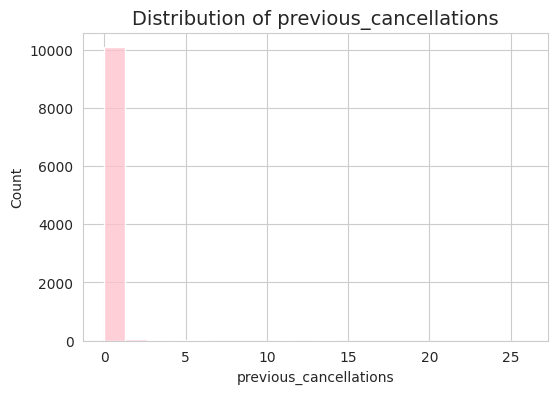

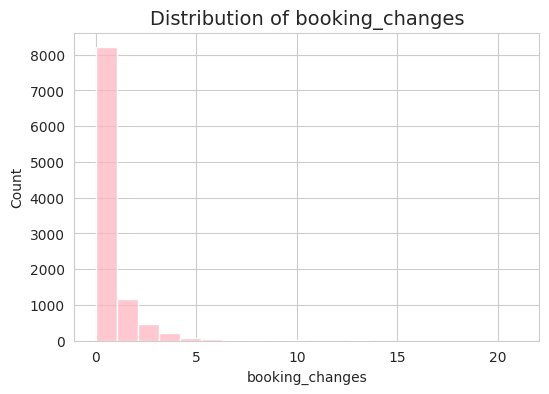

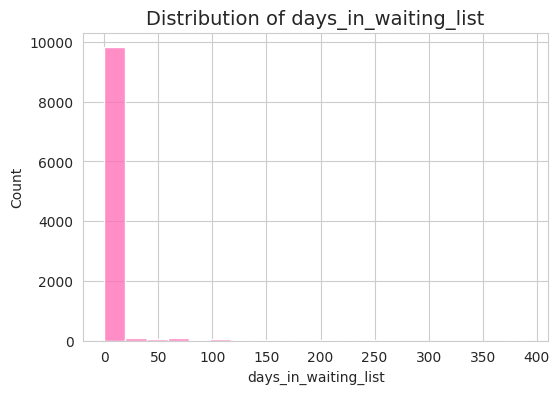

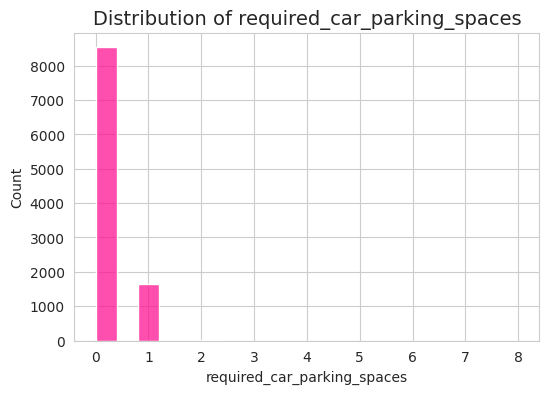

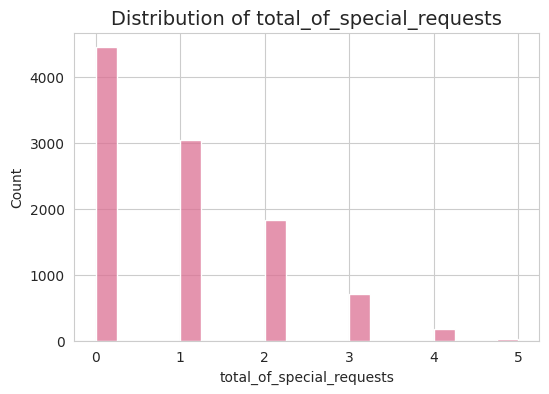

In [ ]:
pink_shades = ["#FFC0CB", "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093"]

for col, color in zip(META["num_cols"], pink_shades * 10):  # repeat if more cols
    plt.figure(figsize=(6,4))
    sns.histplot(df1[col], bins=20, kde=False, color=color)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



### Univariate: categorical counts

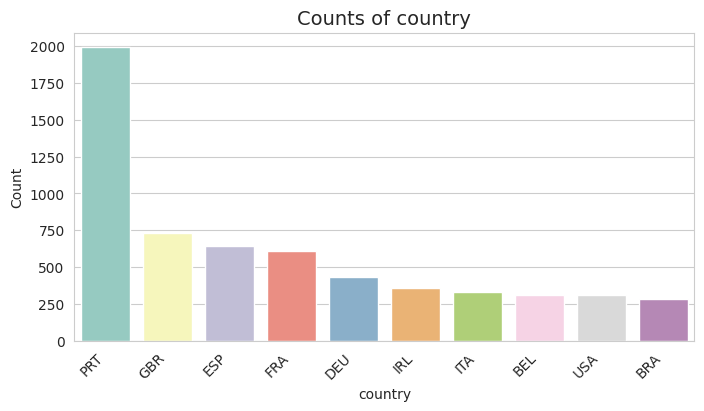

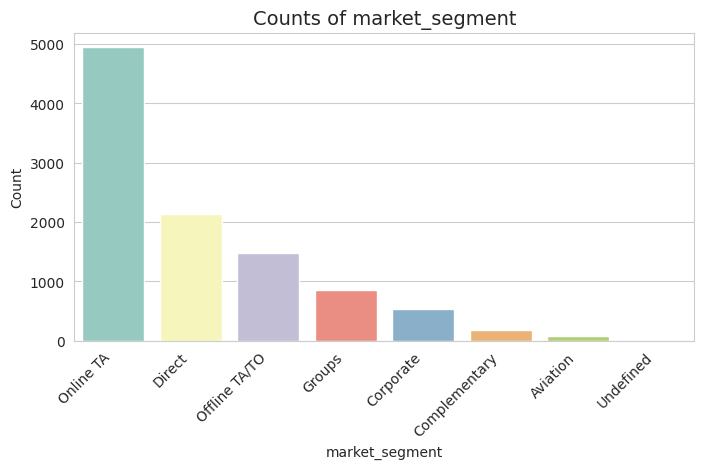

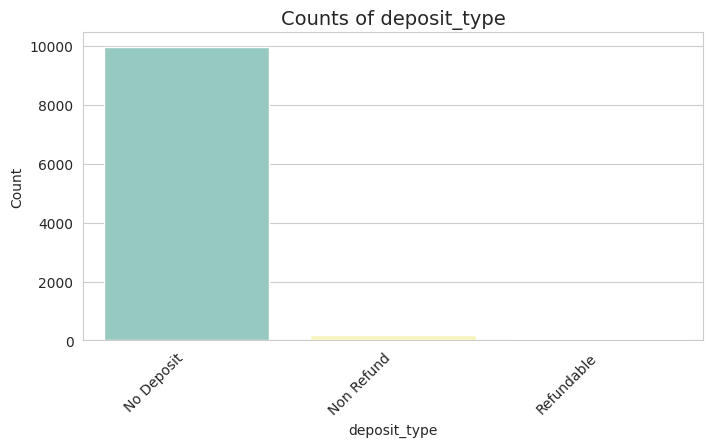

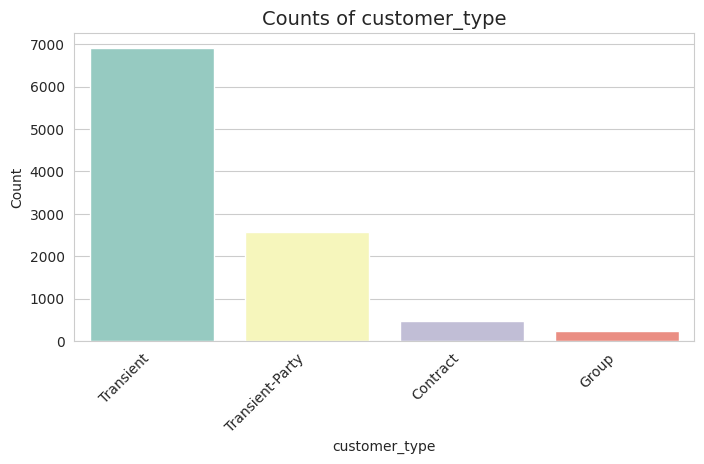

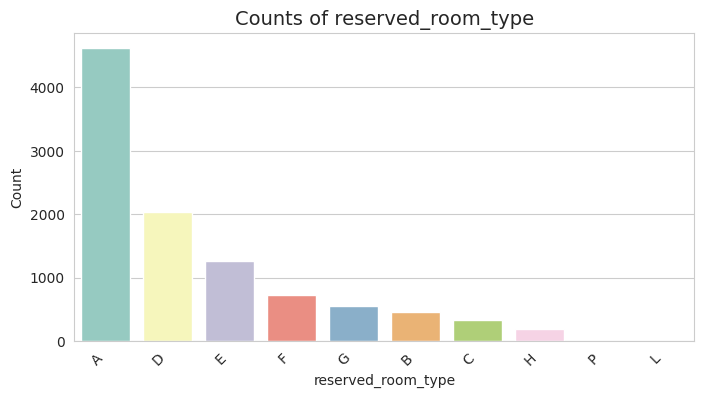

In [ ]:
for col in META["cat_cols"]:
    plt.figure(figsize=(8,4))

    if col.lower() == "country":
        order = df1[col].value_counts().index[:10]
    else:
        order = df1[col].value_counts().index

    palette = sns.color_palette("Set3", len(order))

    sns.countplot(
        data=df1,
        x=col,
        order=order,
        palette=palette
    )
    plt.title(f"Counts of {col}", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Count")
    plt.show()


### Bivariate: categorical vs target (`is_canceled`)

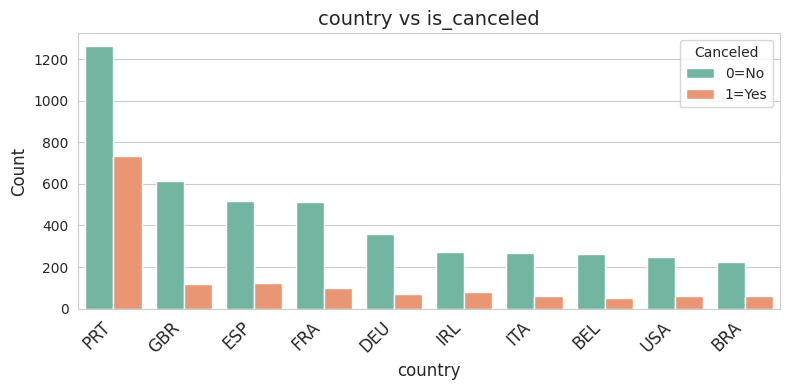

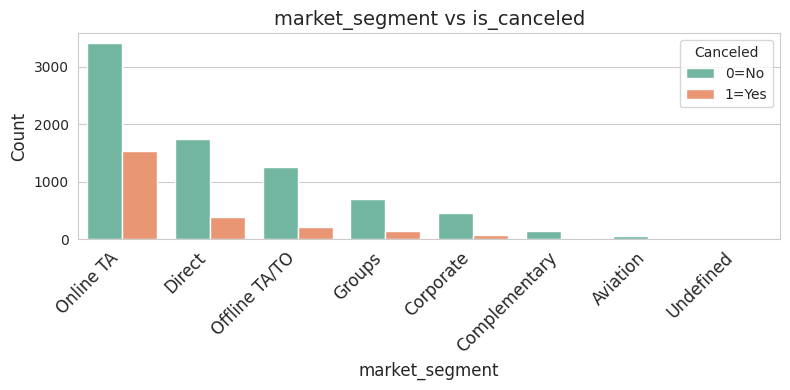

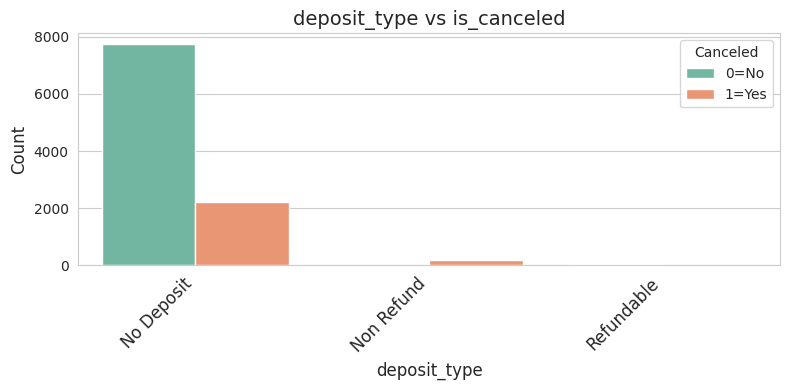

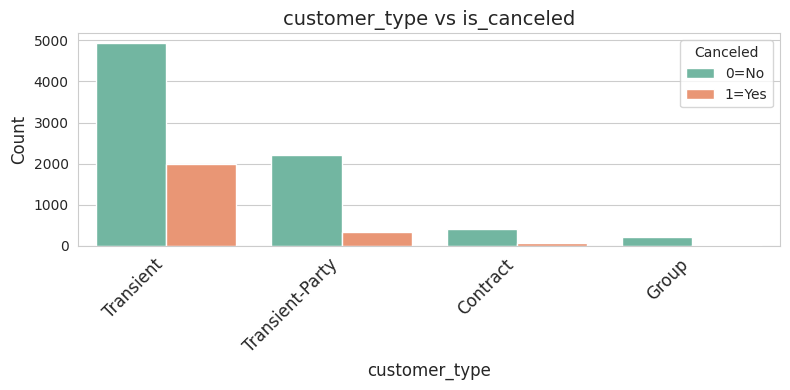

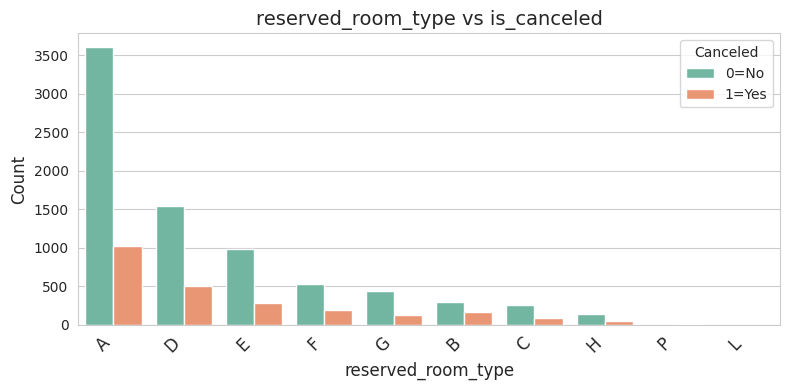

In [ ]:
color_palette = sns.color_palette("Set2")

for col in META["cat_cols"]:
    plt.figure(figsize=(8,4))

    if col == "country":
        top10 = df1[col].value_counts().nlargest(10).index
        order = top10
        data = df1[df1[col].isin(top10)]
    else:
        order = df1[col].value_counts().index
        data = df1

    sns.countplot(
        data=data,
        x=col,
        hue=META["target"],
        order=order,
        palette=color_palette
    )

    plt.title(f"{col} vs {META['target']}", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.legend(title="Canceled", labels=["0=No", "1=Yes"])
    plt.tight_layout()
    plt.show()

### Bivariate: numeric vs target

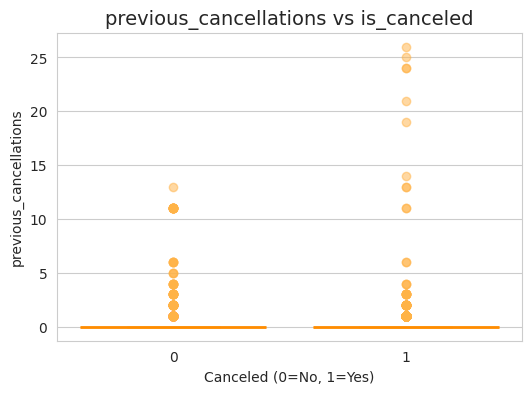

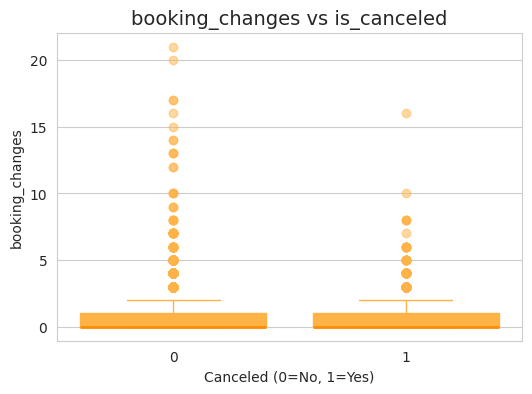

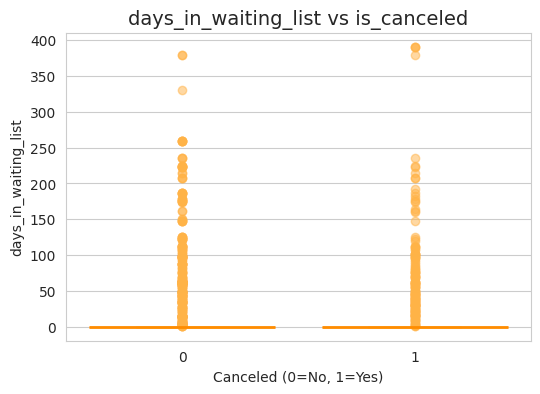

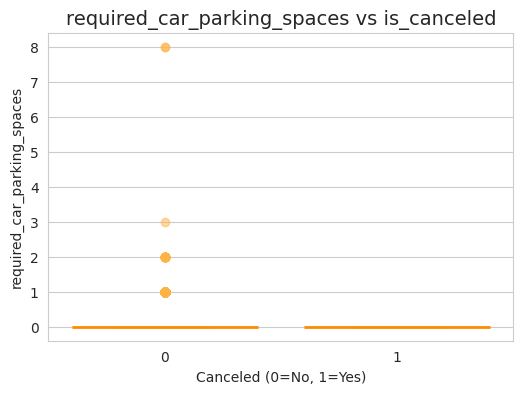

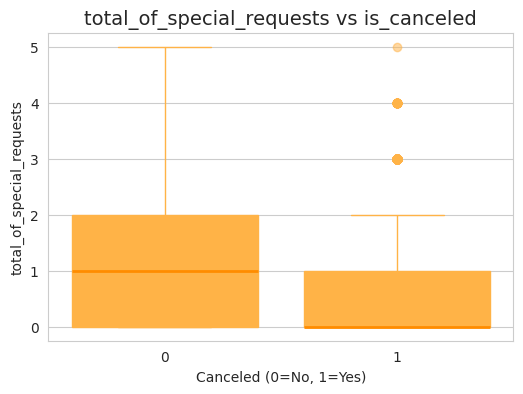

In [ ]:
for col in META["num_cols"]:
    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df1,
        x=META["target"],
        y=col,
        boxprops=dict(facecolor="#FFB347", color="#FFB347"),   # pastel orange fill + border
        whiskerprops=dict(color="#FFB347"),
        capprops=dict(color="#FFB347"),
        medianprops=dict(color="darkorange", linewidth=2),
        flierprops=dict(markerfacecolor="#FFB347", markeredgecolor="#FFB347", alpha=0.5)
    )
    plt.title(f"{col} vs {META['target']}", fontsize=14)
    plt.xlabel("Canceled (0=No, 1=Yes)")
    plt.ylabel(col)
    plt.show()

From the charts above, we can see that's the correlation are pretty diverse. In country vs target, is pretty correlated while the others are not too correlated.

## **Step 5. Leakage Map**

The goal is to check if any features containt **post-outcome information** (stuff that happens after cancellation is known).

If left in, these would cause **data leakge**, as model "cheating" because it sees the future.

However, we don't do anything in this step sice we don't have any obvious leakage features like `reservation_status` or `reservation_status_date`.


So we just record in `META` so it's cleater later when we save the model.

In [ ]:
META["leakage_excluded"] = []

# **Chapter 2. Data Engineering**

In this context, **data engineering** means taking raw dataset that has been cleaned and **transforming it into a machine-readable, consistent, and reproducible format** for modeling.

The goal:
* Keep **feature width & order deterministic**. So if we do streamlit the training vs streamlit inference not mismatches.
* Handle **categorical + numeric transformations** in a single, reusable pipeline.
* Ensure all preprocessing is **fitted on training data only**, not leaking info from validation/test.

## **Step 6. Data splitting**

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

What we do in this steps are;
* Train → for fitting the model + preprocessing. We choose 70% because it gives the model enough data to learn patterns, especially important with categroical diversity (countries, segments) and modest class imbalance.

* Validation (15%) → for hyperparameter tuning & threshold search. The percentage of validation is for hyperparameter tuning, probability calibration, and threshold search.

* Test (15%) → untouched until final evaluation. And it held out until the very end for an unbiased final evaluation. To ensure the reported performance is realistic

Source:https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/?utm_source=chatgpt.com

First, we inputs & target that we've done on step 3

In [ ]:
X = X_all.copy()
y = y_all.copy()

Then, we do train (70%) and temp (30%).

* Done first, stratified by `is_canceled` with a fixed `random_stated`
* Purpose: carve out a large, untouched holdout (Temp) that we won't look at while fitting


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

After that we do validation (15%) + test (15%)

In [ ]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

Now, we want to print the summary.

In [ ]:
print("Shapes:")
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")

print("\nTarget distribution (ratio of classes):")
for name, target in zip(["Train", "Valid", "Test"], [y_train, y_valid, y_test]):
    ratio = target.value_counts(normalize=True).to_dict()
    print(f"{name} -> {ratio}")

Shapes:
Train: (7141, 10), Valid: (1530, 10), Test: (1531, 10)

Target distribution (ratio of classes):
Train -> {0: 0.7633384680016805, 1: 0.23666153199831957}
Valid -> {0: 0.7633986928104575, 1: 0.23660130718954248}
Test -> {0: 0.7635532331809275, 1: 0.2364467668190725}


**Interpretations:**
* **Train set:** 7,141 rows (about 70% of the data).
* **validation set**: 1,530 rows (15% of the data).
* **Test set**: 1,531 rows (15% of data).

For all theree sets:
* About 76% of bookings are not canceled (0)
* About 24% are canceled (1)

Which means we already split correctly 70/15/15.

Then we do visualization of target balance across splits.

In [ ]:
split_labels = (
    ["Train"] * len(y_train) +
    ["Valid"] * len(y_valid) +
    ["Test"]  * len(y_test)
)

In [ ]:
y_concat = pd.concat([y_train, y_valid, y_test], axis=0).reset_index(drop=True)
df_split_balance = pd.DataFrame({"Split": split_labels, "is_canceled": y_concat})


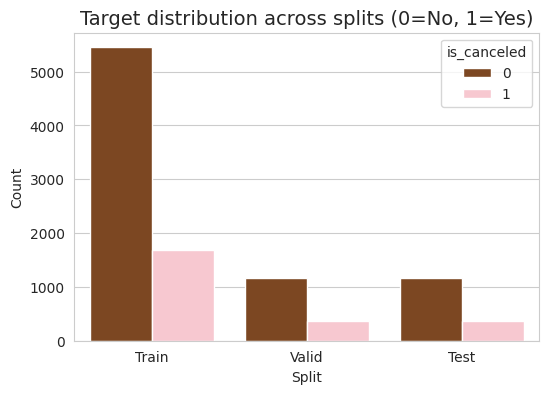

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df_split_balance,
    x="Split",
    hue="is_canceled",
    palette=["saddlebrown", "pink"]
)
plt.title("Target distribution across splits (0=No, 1=Yes)", fontsize=14)
plt.ylabel("Count")
plt.show()

**The char shows**
* Brown bars (0 = not canceled) are always taller than pink bars (1=canceled) in all splits.
* This **ratio looks consistent** across Train, Validation, and Test.
* This means about **3 out of 4 books are not canceled**, and 1 out of 4 are canceled everywhere.

**Is this good? yes**:
* the split preserved the original class imbalance (76/24%).
* no split is skewed. The model will see the same kind of imbalance during training, tuning, and final evaluation.
* this ensure the validation and test results will be fair and realistics.

Lastly, don't forget to save split into `META`.

In [ ]:
META["split"] = {
    "train_size": X_train.shape[0],
    "valid_size": X_valid.shape[0],
    "test_size": X_test.shape[0],
    "random_state": 42
}

## **Step 7. Transformations**


the goal of this step is make preprocessing deterministic and schema-safe;
* **Numeric features** → passthrough (values are already clean counts)
* **Categorical features** → OHE
* **High-cardinality `country`** →  Frequency encoding (replace with its frequency from training data.
* concatenate everything using a **ColumnTransformer** so feature order is locked


On this this step, we pick which columns get which transform. The first one is categorical to OHE except for `country`

In [ ]:
cat_ohe = [c for c in META["cat_cols"] if c != "country"]

Because `country` will be frequency-encoded (1 numeric column)

In [ ]:
freq_col = "country"

Then we do numeric passthrough.

Means, we send numeric columns into the model exactly as they are (no scaling, no encoding) using the ColumnTransformer with "passthrough" for those coloumns.

we do it because our numeric features are already clean and keeps the pipeline simple and deterministic ( no chance of shape/order changing)

In [ ]:
num_features = META["num_cols"]


Then, we do tiny sklearn-style transformer for frequency encoding

In [ ]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        self.freq_map_ = None
        self.fallback_ = 0.0

    def _series(self, X):
        if isinstance(X, pd.DataFrame):
            return pd.Series(X[self.col])
        elif isinstance(X, np.ndarray):
            return pd.Series(X[:, 0])
        return pd.Series(X)

    def fit(self, X, y=None):
        s = self._series(X)
        vc = s.value_counts(normalize=True)
        self.freq_map_ = vc.to_dict()
        self.fallback_ = float(vc.mean()) if len(vc) else 0.0
        return self

    def transform(self, X):
        s = self._series(X)
        vals = s.map(self.freq_map_).fillna(self.fallback_)
        return vals.to_numpy().reshape(-1, 1)

After this, we build **OHE**.

In [ ]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False, dtype=np.float64)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse=False, dtype=np.float64)


Then we compose the ColumnTransformer. Which where one object creates the final, fixed order of features; no manual concat → no order drift.

In [ ]:
try:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse_output=False, dtype=np.float64)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", drop=None, sparse=False, dtype=np.float64)



In [ ]:
cat_ohe   = [c for c in META["cat_cols"] if c != "country"]
freq_col  = "country"
num_feats = META["num_cols"]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_feats),
        ("freq_country", FrequencyEncoder(freq_col), [freq_col]),
        ("cat", ohe, cat_ohe),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

After `ColumnTransformer`, we do fit on train only. So encoders learn only from training data to avoid leakage

In [ ]:
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('freq_country',
                                 FrequencyEncoder(col='country'), ['country']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['market_segment', 'deposit_type',
                                  'customer_type', 'reserved_room_type'])],
                  verbose_feature_names_out=False)

Then extract final feature names. Or expanded the OHE

In [ ]:
ohe_names = list(preprocessor.named_transformers_["cat"].get_feature_names_out(cat_ohe))


In [ ]:
final_feature_names = num_feats + [f"{freq_col}_freq"] + ohe_names
print(f"Total transformed features: {len(final_feature_names)}")
print("First few:", final_feature_names[:10])

Total transformed features: 31
First few: ['previous_cancellations', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'country_freq', 'market_segment_Aviation', 'market_segment_Complementary', 'market_segment_Corporate', 'market_segment_Direct']


Then we do quick sanity check on shapes

In [ ]:
Xt_train = preprocessor.transform(X_train)
Xt_valid = preprocessor.transform(X_valid)
Xt_test  = preprocessor.transform(X_test)

assert Xt_train.shape[1] == len(final_feature_names), "Width mismatch after transform."
assert not np.isnan(Xt_train).any(), "NaNs in transformed train."
assert not np.isnan(Xt_valid).any(), "NaNs in transformed valid."
assert not np.isnan(Xt_test).any(),  "NaNs in transformed test."

print("Shapes OK:", Xt_train.shape, Xt_valid.shape, Xt_test.shape)

Shapes OK: (7141, 31) (1530, 31) (1531, 31)


As usual, save it in joblib bundle

In [ ]:
META.update({
    "feature_names_out": final_feature_names,
    "freq_maps": {
        "country": preprocessor.named_transformers_["freq_country"].freq_map_,
        "fallback": float(preprocessor.named_transformers_["freq_country"].fallback_),
    }
})

## **Step 8. Preprocessing pipelines**

While on this steps the main pictures that we are going to do are;
* Build a ColumnTransformer that applies the transformations.
* Wrap it in a **full pipeline** together with the model. So preprocessing and model always stick together.
* Visualize or print transformed feature shapes and save into `META` for joblib bundling.

First import and pick a simple baseline model.
* We use `LogRec` since its interpretable and works well as a first baseline.
*` class_weight="balanced"` compensates for the 24% canceled vs 76% not canceled imbalance.
* `random_state=42` for reproducibility.

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

Then, we move on build the full pipeline. Which means preprocessing + model.

This phase keeps everything together and guarantees the same preprocessing is applied in trining and inference (no drift).

In [ ]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

Then, we fit the pipeline on training data.

* This runs your preprocessor → transform features → pass them into logistic regression → fit coefficients.

* Preprocessor is fitted once on train (OHE categories + country frequency map stay fixed)

In [ ]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests']),
                                                 ('freq_country',
                                                  FrequencyEncoder(col='country'),
                                                  ['country']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['market_segment',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'reserved_room_type'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

After we see the pipeline, we do quick check on validation

This is just a sanity check to make sure the pipeline works end-to-end.

In [ ]:
y_pred_valid = pipe.predict(X_valid)
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1168
           1       0.44      0.82      0.57       362

    accuracy                           0.71      1530
   macro avg       0.68      0.75      0.67      1530
weighted avg       0.81      0.71      0.73      1530



**Interpretations:**
* For **not canceled (0)**: the model is  accurate when it says "not canceled" (92% correct), but it misses quire a feq real "not canceled" cases (only catches 67%).
* For **canceled(1)**: the mode finds most of the cancelalations (82% recall), but almost half of the ones it flags are actually not canceled (precision only 44%).
* Overall accuracy is 71%, but the main issue is **too many false alarms for cancellations**.

Then, we want to see how the PR Curve can help pick a better balance point on our validation set.

To do that, first we define the probabilities for class 1 (canceled)

In [ ]:
y_proba_valid = pipe.predict_proba(X_valid)[:, 1]


Then we compute precision, recall, thresholds. After the computing we compute area under the PR curve.

In [ ]:
prec, rec, thr = precision_recall_curve(y_valid, y_proba_valid)
pr_auc = auc(rec, prec)


Here's the visualization

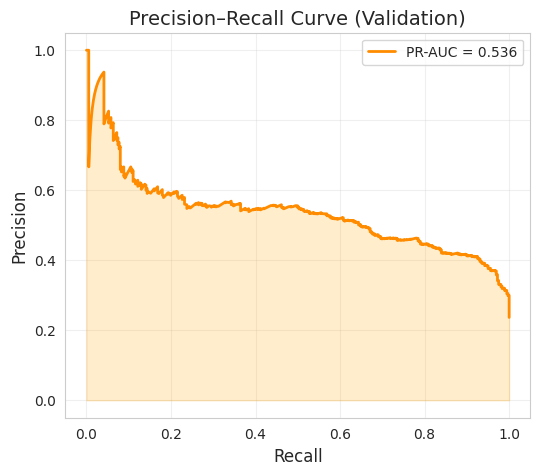

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(rec, prec, color="darkorange", lw=2, label=f"PR-AUC = {pr_auc:.3f}")
plt.fill_between(rec, prec, alpha=0.2, color="orange")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curve (Validation)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**Interpretations:**
* **X-axis (Recall)**: how many of the recal cancellations the model catches.
* **Y-axis (Precision)**: how many of the predicted cancellations are actually correct.
* **Orange curve**: the trade-off between the two as we move the decision threshold.
* **PR-AUC = 0.536**, the overall area under the curve (higher = better; random guessing would give 0.24, equal to the proportion of class 1).

-------

**Key takeaways**
* At **very high recall (close to 1.0)** → the model finds almost all cancellations, but precision drops badly (many false alarms).
* At **very high precision (close to 1.0)** → precision is good, but recall is close to 0 (miss most cancellations.)
* **The sweet spot is somewhere in the middle**.
* With **PR-AUC=0.536**, the model is better than random (0.24) but still leaves lots of room to improve

After the check we confirms the pipeline's model expects exactly this feature width/prder, that's why we **save feature names and schema for reference.**

In [ ]:
META["pipeline_feature_names"] = META["feature_names_out"]

# **Chapter 3 | Modeling & Evaluation**

In this last chapter, we take the preprocessed, schema-locked data from Chapter 2 and **train, select, and validate** models in a way that is **reproducible and business-aligned**.

**The goals:**
* **Find the best model using stratified cross-validation** with **PR-AUC**.
* Keeps **preprocessing + model bound in one Pipelie**, so train ↔︎ Streamlit behavior is identical.
* **Make probabilities reliable** (calibration) and **choose an operationg threshold** that meets our precision/recall target.
* Produce **transparent explanations** (feature importance & SHAP) and clean final test report.

## **Step 9.Modeling & Cross Validation**

We do pre-check to ensure earlier steps exsist

In [ ]:
assert 'preprocessor' in globals(), "Run Step 7 to build `preprocessor` first."
for v in ['X_train','X_valid','y_train','y_valid']:
    assert v in globals(), f"Missing {v} — run Step 6 (splitting)."

np.random.seed(42)

Then we create models that is imbalance aware

In [ ]:
neg, pos = int((y_train==0).sum()), int((y_train==1).sum())
scale_pos_weight = neg / max(pos,1)  #

logreg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
rf     = RandomForestClassifier(n_estimators=500, class_weight="balanced_subsample",
                                n_jobs=-1, random_state=42)
hgb    = HistGradientBoostingClassifier(learning_rate=0.1, max_leaf_nodes=31, random_state=42)


In [ ]:
try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=600, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, eval_metric="logloss",
        tree_method="hist", random_state=42, scale_pos_weight=scale_pos_weight
    )
    xgb_available = True
except Exception:
    xgb_available = False

After that, we make pipelines (plain)

In [ ]:
plain = {
    "LogReg (plain)":       Pipeline([("preprocessor", preprocessor), ("model", logreg)]),
    "RandomForest (plain)": Pipeline([("preprocessor", preprocessor), ("model", rf)]),
    "HistGB (plain)":       Pipeline([("preprocessor", preprocessor), ("model", hgb)]),
}
if xgb_available:
    plain["XGBoost (plain)"] = Pipeline([("preprocessor", preprocessor), ("model", xgb)])


Now make the SMOTE pipeline.

In [ ]:

smote = SMOTE(sampling_strategy="auto", k_neighbors=5, random_state=42)
smoted = {
    "LogReg + SMOTE": ImbPipeline([
        ("preprocessor", preprocessor), ("smote", smote),
        ("model", LogisticRegression(max_iter=2000, class_weight=None, random_state=42))
    ]),
    "LogReg + SMOTE + CW": ImbPipeline([
        ("preprocessor", preprocessor), ("smote", smote),
        ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ]),
    "RandomForest + SMOTE": ImbPipeline([
        ("preprocessor", preprocessor), ("smote", smote),
        ("model", RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1))
    ]),

}

Then we do cross-validation, to know best one in all metrics.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
}


In [ ]:
def cv_scores(pipes, title):
    print(f"\n=== {title} ===")
    out = {}
    for name, pl in pipes.items():
        res = cross_validate(pl, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        summ = {m: (res[f'test_{m}'].mean(), res[f'test_{m}'].std()) for m in scoring.keys()}
        out[name] = {k: {"mean": float(v[0]), "std": float(v[1])} for k,v in summ.items()}
        print(f"{name:22s}  "
              f"PR-AUC={summ['pr_auc'][0]:.3f}±{summ['pr_auc'][1]:.3f} | "
              f"ROC-AUC={summ['roc_auc'][0]:.3f}±{summ['roc_auc'][1]:.3f} | "
              f"F1={summ['f1'][0]:.3f}±{summ['f1'][1]:.3f} | "
              f"P={summ['precision'][0]:.3f}±{summ['precision'][1]:.3f} | "
              f"R={summ['recall'][0]:.3f}±{summ['recall'][1]:.3f}")
    return out

cv_plain = cv_scores(plain,  "CV (No SMOTE)")
cv_smote = cv_scores(smoted, "CV (With SMOTE)")


=== CV (No SMOTE) ===
LogReg (plain)          PR-AUC=0.560±0.038 | ROC-AUC=0.824±0.013 | F1=0.579±0.011 | P=0.449±0.014 | R=0.817±0.026
RandomForest (plain)    PR-AUC=0.446±0.033 | ROC-AUC=0.745±0.017 | F1=0.386±0.024 | P=0.380±0.031 | R=0.392±0.020
HistGB (plain)          PR-AUC=0.591±0.030 | ROC-AUC=0.832±0.014 | F1=0.433±0.014 | P=0.553±0.036 | R=0.357±0.021
XGBoost (plain)         PR-AUC=0.606±0.035 | ROC-AUC=0.841±0.015 | F1=0.593±0.023 | P=0.461±0.023 | R=0.832±0.023

=== CV (With SMOTE) ===
LogReg + SMOTE          PR-AUC=0.562±0.039 | ROC-AUC=0.824±0.014 | F1=0.578±0.013 | P=0.451±0.017 | R=0.807±0.025
LogReg + SMOTE + CW     PR-AUC=0.562±0.039 | ROC-AUC=0.824±0.014 | F1=0.578±0.013 | P=0.451±0.017 | R=0.807±0.025
RandomForest + SMOTE    PR-AUC=0.422±0.030 | ROC-AUC=0.743±0.018 | F1=0.400±0.029 | P=0.372±0.034 | R=0.434±0.024


The best model is XGBoost (plain), as we focusing on PR-AUC and also Recall. Also from overall, it also shown the best result.

After that, we fit the winner on TRAIN and evaluate on VALID with all metrics

In [ ]:
winner_pipe = (plain.get(winner_name) or smoted.get(winner_name))
best_pipeline = deepcopy(winner_pipe).fit(X_train, y_train)


Then we do the validation process

In [ ]:
y_val_proba = best_pipeline.predict_proba(X_valid)[:, 1]
def metrics_at_threshold(th):
    y_hat = (y_val_proba >= th).astype(int)
    return {
        "PR-AUC": average_precision_score(y_valid, y_val_proba),
        "ROC-AUC": roc_auc_score(y_valid, y_val_proba),
        "F1": f1_score(y_valid, y_hat, zero_division=0),
        "Precision": precision_score(y_valid, y_hat, zero_division=0),
        "Recall": recall_score(y_valid, y_hat, zero_division=0),
        "Threshold": th
    }

In [ ]:
print(f"\n=== Validation metrics — {winner_name} ===")
for th in [0.30, 0.50, 0.70]:
    m = metrics_at_threshold(th)
    print(f"@thr={th:.2f}  PR-AUC={m['PR-AUC']:.3f}  ROC-AUC={m['ROC-AUC']:.3f}  "
          f"F1={m['F1']:.3f}  P={m['Precision']:.3f}  R={m['Recall']:.3f}")


=== Validation metrics — XGBoost (plain) ===
@thr=0.30  PR-AUC=0.617  ROC-AUC=0.846  F1=0.581  P=0.418  R=0.953
@thr=0.50  PR-AUC=0.617  ROC-AUC=0.846  F1=0.586  P=0.452  R=0.834
@thr=0.70  PR-AUC=0.617  ROC-AUC=0.846  F1=0.547  P=0.559  R=0.536


After that, we do hyperparameter tuning in winner model which in our case is on XGBoost (plain). It's simply to increase accuracy and so will be less False Positive.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {}
if "HistGB" in winner_name:
    param_dist = {
        "model__learning_rate":    [0.03, 0.05, 0.07, 0.10],
        "model__max_leaf_nodes":   [15, 31, 63],
        "model__min_samples_leaf": [10, 20, 50, 80],
        "model__l2_regularization":[0.0, 0.1, 0.5, 1.0],
        "model__max_iter":         [200, 300, 400]
    }
elif "XGBoost" in winner_name:
    param_dist = {
        "model__n_estimators":   [400, 600, 800],
        "model__max_depth":      [3, 4, 6],
        "model__learning_rate":  [0.03, 0.05, 0.1],
        "model__subsample":      [0.7, 0.8, 1.0],
        "model__colsample_bytree":[0.6, 0.8, 1.0],
        "model__min_child_weight":[1, 5, 10],
        "model__gamma":          [0, 1, 5],
    }
elif "RandomForest" in winner_name:
    param_dist = {
        "model__n_estimators":     [300, 500, 800],
        "model__max_depth":        [None, 6, 10, 14],
        "model__min_samples_split":[2, 5, 10],
        "model__min_samples_leaf": [1, 2, 5],
        "model__max_features":     ["sqrt", 0.5, None],
    }
elif "LogReg" in winner_name:
    param_dist = {
        "model__C":      [0.1, 0.5, 1.0, 2.0, 5.0],
        "model__penalty":["l2"],
        "model__solver": ["lbfgs", "liblinear"],
    }

search = RandomizedSearchCV(
    estimator=winner_pipe,
    param_distributions=param_dist,
    n_iter=25, scoring="average_precision",
    cv=cv, n_jobs=-1, random_state=42, verbose=1
)


Then we re-evaluated tuned winner on validations (all metrics). Which started compute validation metrics again at a few threshold.

In [ ]:
y_val_proba = best_pipeline.predict_proba(X_valid)[:, 1]
def line(th):
    y_hat = (y_val_proba >= th).astype(int)
    return (f"@thr={th:.2f}  "
            f"PR-AUC={average_precision_score(y_valid, y_val_proba):.3f}  "
            f"ROC-AUC={roc_auc_score(y_valid, y_val_proba):.3f}  "
            f"F1={f1_score(y_valid, y_hat, zero_division=0):.3f}  "
            f"P={precision_score(y_valid, y_hat, zero_division=0):.3f}  "
            f"R={recall_score(y_valid, y_hat, zero_division=0):.3f}")
print("\n=== Validation metrics (final winner) ===")
for th in [0.30, 0.50, 0.60, 0.70, 0.80]:
    print(line(th))


=== Validation metrics (final winner) ===
@thr=0.30  PR-AUC=0.617  ROC-AUC=0.846  F1=0.581  P=0.418  R=0.953
@thr=0.50  PR-AUC=0.617  ROC-AUC=0.846  F1=0.586  P=0.452  R=0.834
@thr=0.60  PR-AUC=0.617  ROC-AUC=0.846  F1=0.597  P=0.502  R=0.738
@thr=0.70  PR-AUC=0.617  ROC-AUC=0.846  F1=0.547  P=0.559  R=0.536
@thr=0.80  PR-AUC=0.617  ROC-AUC=0.846  F1=0.371  P=0.648  R=0.260


Then we previow precision-first threshold that fits our guardrail

In [ ]:
target_precision = 0.60
prec, rec, thr = precision_recall_curve(y_valid, y_val_proba)
ok = np.where(prec >= target_precision)[0]
if len(ok) > 0:
    i_star = ok[np.argmax(rec[ok])]
    th_star = thr[max(i_star-1, 0)]
    print(f"\nPreview: Precision≥{target_precision:.2f} at threshold≈{th_star:.3f} "
          f"(precision≈{prec[i_star]:.3f}, recall≈{rec[i_star]:.3f})")
else:
    print(f"\nNo threshold reaches Precision≥{target_precision:.2f} on validation.")


Preview: Precision≥0.60 at threshold≈0.750 (precision≈0.600, recall≈0.381)


And save it to joblib

In [ ]:
os.makedirs("artifacts", exist_ok=True)
meta = {
    "winner_name": winner_name,
    "tie_margin": TIE_MARGIN,
    "cv_results": all_cv,
    "expected_input_cols": META.get("expected_input_cols"),
    "schema_dtypes": {k:str(v) for k,v in META.get("schema_dtypes",{}).items()},
    "num_cols": META.get("num_cols"),
    "cat_cols": META.get("cat_cols"),
    "feature_names_out": META.get("feature_names_out"),
    "freq_maps": META.get("freq_maps"),
    "split": META.get("split"),
    "versions": {
        "sklearn": sklearn.__version__,
        "pandas": pd.__version__,
        "numpy": np.__version__,
    }
}

In [ ]:
joblib.dump({"pipeline": best_pipeline, "meta": meta}, "artifacts/hotel_cancellation_pipeline.joblib")
with open("artifacts/hotel_cancellation_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("\n Saved:")
print(" - artifacts/hotel_cancellation_pipeline.joblib")
print(" - artifacts/hotel_cancellation_meta.json")


 Saved:
 - artifacts/hotel_cancellation_pipeline.joblib
 - artifacts/hotel_cancellation_meta.json


## **Step 10.Probability Calibration & Thresholding**

In this step we'll do:
* Calibrate the chosen model's probabilities **without touching the test set**.
* From the validation set, **pick a decision threshold** that mattches our policy
* Save the `best_threshold` in metadata

**Outcome**: trustworhty probabilities and a threshold that aligns with business costs (False positives vs false negatives).

Like usual, we do pre-checks to ensure its still okay and the data that we need still there.

In [ ]:
assert 'best_pipeline' in globals(), "Need the tuned winner from Step 9."
for v in ['X_valid','y_valid']:
    assert v in globals(), f"Missing {v}."


Then it's all set and we do baseline (uncalibrated) probabilities & metrics. So we have reference before the calibration.

In [ ]:
y_val_proba_raw = best_pipeline.predict_proba(X_valid)[:, 1]


Then we make the baseline of the uncalibrated one

In [ ]:
baseline = {
    "PR_AUC":  float(average_precision_score(y_valid, y_val_proba_raw)),
    "ROC_AUC": float(roc_auc_score(y_valid, y_val_proba_raw)),
    "BRIER":   float(brier_score_loss(y_valid, y_val_proba_raw)),
}
print("[11.1] Uncalibrated on validation:", baseline)

[11.1] Uncalibrated on validation: {'PR_AUC': 0.617256757975771, 'ROC_AUC': 0.8462664610610762, 'BRIER': 0.16143173335403024}


After that we fit two calibrators (sigmoid & isotonic) on validation. We want to compare Platt (sigmoid) vs isotonic and keep the better one.

This step, we are just calibrating and evaluation on validation. The test set will be done later on step 11.

That's why we wrap the winner and use `cv="previt"`, so we dont refit the base model

In [ ]:
cal_sig = CalibratedClassifierCV(estimator=best_pipeline, method="sigmoid",  cv="prefit")
cal_iso = CalibratedClassifierCV(estimator=best_pipeline, method="isotonic", cv="prefit")

Then we calibrate on the validation split (model is already fitted, use `cv=prefit`

In [ ]:
cal_sig.fit(X_valid, y_valid)
cal_iso.fit(X_valid, y_valid)

CalibratedClassifierCV(cv='prefit',
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   'passthrough',
                                                                                   ['previous_cancellations',
                                                                                    'booking_changes',
                                                                                    'days_in_waiting_list',
                                                                                    'required_car_parking_spaces',
                                                                                    'total_of_special_requests']),
                                                                                  ('freq_country',
                                                                                   FrequencyEncoder(col='country'),
                                                                                   ['country']),
                                                                                  ('cat',
                                                                                   OneHotEncoder(handle_unkn...
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=0.05,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=4,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=600,
                                                                n_jobs=None,
                                                                num_parallel_tree=None, ...))]),
                       method='isotonic')

Now we are going to comparede the two and choose the better one (it will be unchanged).

In [ ]:
proba_sig = cal_sig.predict_proba(X_valid)[:, 1]
proba_iso = cal_iso.predict_proba(X_valid)[:, 1]


In [ ]:
def cal_summary(p):
    return {
        "PR_AUC":  float(average_precision_score(y_valid, p)),
        "ROC_AUC": float(roc_auc_score(y_valid, p)),
        "BRIER":   float(brier_score_loss(y_valid, p)),
    }

In [ ]:
sig_summary = cal_summary(proba_sig)
iso_summary = cal_summary(proba_iso)


And we prefer lower Brier as for better calibration. Which is tie-break with higher PR-AUC

In [ ]:
if (sig_summary["BRIER"] < iso_summary["BRIER"] or
   (sig_summary["BRIER"] == iso_summary["BRIER"] and sig_summary["PR_AUC"] >= iso_summary["PR_AUC"])):
    CAL_METHOD = "sigmoid"; calibrated_pipeline = cal_sig;  y_val_proba_cal = proba_sig;  cal_metrics = sig_summary
else:
    CAL_METHOD = "isotonic"; calibrated_pipeline = cal_iso; y_val_proba_cal = proba_iso; cal_metrics = iso_summary
print(f"[11.3] Chosen calibration: {CAL_METHOD}  |  metrics={cal_metrics}")

[11.3] Chosen calibration: isotonic  |  metrics={'PR_AUC': 0.6064001476375784, 'ROC_AUC': 0.8507601415272837, 'BRIER': 0.12543955759558942}


The chosen calibrators are isotonic. And now we want to check how calibration affect the PR curve through **Precision-Recall curve after calibration**

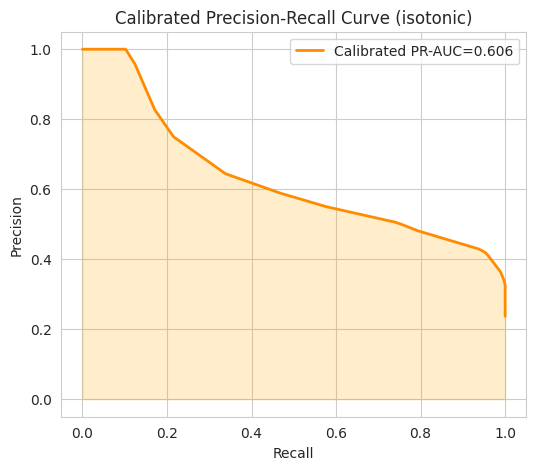

In [ ]:
prec, rec, _ = precision_recall_curve(y_valid, y_val_proba_cal)
pr_auc_cal = average_precision_score(y_valid, y_val_proba_cal)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, color="darkorange", lw=2, label=f"Calibrated PR-AUC={pr_auc_cal:.3f}")
plt.fill_between(rec, prec, alpha=0.2, color="orange")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Calibrated Precision-Recall Curve ({CAL_METHOD})")
plt.legend()
plt.show()

**Interpretaions**
* PR-AUC = 0.606 → This is the area under the Precision–Recall curve after calibration. It’s slightly lower than your uncalibrated PR-AUC (≈0.617), which means calibration didn’t boost ranking performance, but that’s normal—calibration focuses on probability quality, not ranking.
* **Precision starts high** at very low recall (left side), then drops as recall increases. This is expected: when model only makes very confident "Yes" predictions, its often correct (high precision), but it misses many positives (low recall). As we allow the model to predict more positives, recall rises, but precision falls.
* **Smooth curve** → suggests the calibrated probabilities are well-behaved and not too extreme. Isotonic calibration typically makes probabilities less biases (closer to true likelihoods).


**Takeaways**
* Calibration (isotonic) made probability outputs more reliable.
* Our model is still better at **catching positives (high recall)** than being precise.


Next we **pick a precision-first threshold** to minimize false positives.

In [ ]:
TARGET_PRECISION = 0.60

prec, rec, thr = precision_recall_curve(y_valid, y_val_proba_cal)

In [ ]:
ok = np.where(prec >= TARGET_PRECISION)[0]
if len(ok) > 0:
    i_star = ok[np.argmax(rec[ok])]
    THRESHOLD = float(thr[max(i_star-1, 0)])
    picked = {"threshold": THRESHOLD, "precision": float(prec[i_star]), "recall": float(rec[i_star])}
    msg = f"Precision≥{TARGET_PRECISION:.2f} achieved"
else:

    grid = np.linspace(0.01, 0.99, 99)
    f1_vals = [f1_score(y_valid, (y_val_proba_cal>=t).astype(int), zero_division=0) for t in grid]
    THRESHOLD = float(grid[int(np.argmax(f1_vals))])
    y_tmp = (y_val_proba_cal >= THRESHOLD).astype(int)
    picked = {
        "threshold": THRESHOLD,
        "precision": float(precision_score(y_valid, y_tmp, zero_division=0)),
        "recall":    float(recall_score(y_valid, y_tmp, zero_division=0)),
        "f1":        float(max(f1_vals))
    }
    msg = "Precision guardrail unmet → using F1-optimal threshold"

print(f"[11.4] Chosen threshold: {picked}  ({msg})")

[11.4] Chosen threshold: {'threshold': 0.4791666567325592, 'precision': 0.6424870466321243, 'recall': 0.3425414364640884}  (Precision≥0.60 achieved)


And we want to quick table at a few fixed tresholds to see the trade- off

In [ ]:
rows = []
for t in [0.30, 0.50, 0.60, 0.70, THRESHOLD]:
    y_hat = (y_val_proba_cal >= t).astype(int)
    rows.append({
        "threshold": round(float(t),3),
        "precision": float(precision_score(y_valid, y_hat, zero_division=0)),
        "recall":    float(recall_score(y_valid, y_hat, zero_division=0)),
        "f1":        float(f1_score(y_valid, y_hat, zero_division=0))
    })
pd.DataFrame(rows).drop_duplicates(subset=["threshold"]).sort_values("threshold")

,threshold,precision,recall,f1
0,0.300,0.500000,0.754144,0.601322
4,0.479,0.588235,0.469613,0.522273
1,0.500,0.642487,0.342541,0.446847
2,0.600,0.812500,0.179558,0.294118
3,0.700,0.957447,0.124309,0.220049


**Interpretations**
* 0.30 → Precision = 0.50, Recall = 0.75, F1 ≈ 0.60
→ Balanced trade-off: recall is quite high (75%), precision is moderate (50%). Best F1 here.
* 0.479 → Precision ≈ 0.59, Recall ≈ 0.47, F1 ≈ 0.52
→ More balanced but weaker overall: recall drops, precision improves slightly.
* 0.50 → Precision ≈ 0.64, Recall ≈ 0.34, F1 ≈ 0.45
→ High precision, but recall is already halved.
* 0.60 → Precision ≈ 0.81, Recall ≈ 0.18, F1 ≈ 0.29
→ Strong precision, but recall collapses → catches only 18% of cancels.
* 0.70 → Precision ≈ 0.96, Recall ≈ 0.12, F1 ≈ 0.22
→ Very few false positives (great precision), but misses almost all cancellations (recall only 12%).


**What this means:**
* If our business wants fewer false alarms (FP), theresholds 0.60-0.70 are safer, but we will miss cancellations.
* If cares more about catching cancellations, thresholds 0.30 is better (higher recall, balanced F1).

**Final, we use 0.30**, since F1 is highest and recall is strong without precision being too week.

That's why we lock the threshold first

In [ ]:
THRESHOLD = 0.30
META["best_threshold"] = float(THRESHOLD)
print(f"Locked decision threshold: {THRESHOLD}")

Locked decision threshold: 0.3


Then we compute final validation metrics at the locked threshold

In [ ]:
y_val_pred_cal = (y_val_proba_cal >= THRESHOLD).astype(int)


In [ ]:
final_val = {
    "CalibrationMethod": CAL_METHOD,
    "Threshold": float(THRESHOLD),
    "PR_AUC":  float(average_precision_score(y_valid, y_val_proba_cal)),
    "ROC_AUC": float(roc_auc_score(y_valid, y_val_proba_cal)),
    "Precision": float(precision_score(y_valid, y_val_pred_cal, zero_division=0)),
    "Recall":    float(recall_score(y_valid, y_val_pred_cal, zero_division=0)),
    "F1":        float(f1_score(y_valid, y_val_pred_cal, zero_division=0)),
    "Brier":     float(brier_score_loss(y_valid, y_val_proba_cal)),
    "ConfusionMatrix": confusion_matrix(y_valid, y_val_pred_cal).tolist()
}
print("[11.5] Final validation (calibrated):", final_val)


[11.5] Final validation (calibrated): {'CalibrationMethod': 'isotonic', 'Threshold': 0.3, 'PR_AUC': 0.6064001476375784, 'ROC_AUC': 0.8507601415272837, 'Precision': 0.5, 'Recall': 0.7541436464088398, 'F1': 0.6013215859030837, 'Brier': 0.12543955759558942, 'ConfusionMatrix': [[895, 273], [89, 273]]}


In [ ]:
FINAL_MODEL = calibrated_pipeline
FINAL_THRESHOLD = THRESHOLD

## **Step 11. Evaluation & Diagnostics**

In this step, we'll do:
* Lock results on the **hold-out-test set**: PR-AUC, ROC-AUC, precision/recall at the chosen threshold, confusion matrix.
* Include calibration curve, error analysis (where and why we miss), and final SHAP snapshots on test examples.
* Confirm stability vs validation (no overfitting)

**Outcome:**: a credible, final performance report

Like usual, we do the pre-checks

In [ ]:
assert 'FINAL_MODEL' in globals() and 'FINAL_THRESHOLD' in globals(), "Run Step 11 first."
for v in ['X_test','y_test']:
    assert v in globals(), f"Missing {v} — check Step 6 splits."

Then we test probabilities (calibrated) + metrics at locked threshold. This is the **final, honest** performance on unseen data. This time we do calibrated probabilities on TEST first

In [ ]:
y_test_proba = FINAL_MODEL.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= FINAL_THRESHOLD).astype(int)

Then we make the test report

In [ ]:
test_report = {
    "PR_AUC":  float(average_precision_score(y_test, y_test_proba)),
    "ROC_AUC": float(roc_auc_score(y_test, y_test_proba)),
    "Brier":   float(brier_score_loss(y_test, y_test_proba)),
    "Precision@thr": float(precision_score(y_test, y_test_pred, zero_division=0)),
    "Recall@thr":    float(recall_score(y_test, y_test_pred, zero_division=0)),
    "F1@thr":        float(f1_score(y_test, y_test_pred, zero_division=0)),
    "Threshold":     float(FINAL_THRESHOLD),
    "ConfusionMatrix": confusion_matrix(y_test, y_test_pred).tolist()
}
print("[12.1] TEST (calibrated, locked threshold):", test_report)

[12.1] TEST (calibrated, locked threshold): {'PR_AUC': 0.5673537883824807, 'ROC_AUC': 0.8290400257102213, 'Brier': 0.1321387526187015, 'Precision@thr': 0.47927927927927927, 'Recall@thr': 0.7348066298342542, 'F1@thr': 0.5801526717557252, 'Threshold': 0.3, 'ConfusionMatrix': [[880, 289], [96, 266]]}


After we have the test report, we are going to check PR curve plot on TEST

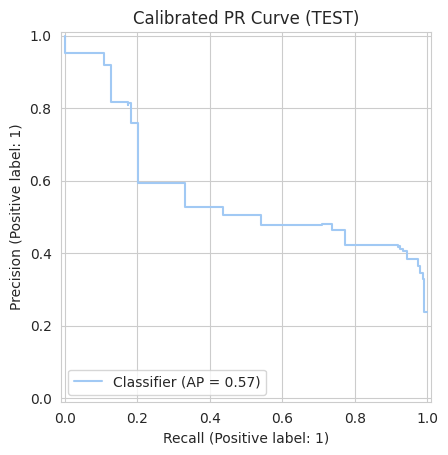

In [ ]:
disp = PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Calibrated PR Curve (TEST)")
plt.show()

**Interpretations**
* Y-axis (Precision): how many predicted cancellations were truly canceled.
* X-axis (Recall): how many of the true cancellations the model caught.
* Curve: shows the trade-off between precision and recall at different thresholds.
* AP = 0.57: this is the average precision, i.e. the area under this curve (same as PR-AUC).


**What it means**
1. AP = 0.57 → the model is moderately good, above random (baseline AP ≈ class ratio = ~0.23). That means the model learns meaningful cancellation patterns.
2. High precision at low recall (left side): if you want to be very sure a booking is risky (precision > 0.8), you’ll only catch a small fraction of all cancellations (low recall).
3. Higher recall, lower precision (right side): if you try to catch most cancellations, many false alarms will creep in.
4. The calibration (isotonic) smoothed probabilities, so the curve shape looks realistic rather than jagged.

**In business terms:**
* If our priority is to avoid false positives (don’t annoy customers wrongly flagged as canceling), we’ll operate on the left side of the curve (lower recall, higher precision).
* If our priority is to catch as many cancellations as possible, we’ll operate on the right side (higher recall, lower precision).

Now we extract baseline pipeline (preprocessor _ model) for interpretability.

Final_Model is  `CalibratedClassifierCV(estimator=best_pipeline, cv='prefit'`

In [ ]:
base_pipe = getattr(FINAL_MODEL, "estimator", None) or getattr(FINAL_MODEL, "base_estimator", None)
assert base_pipe is not None, "Could not access base estimator from the calibrated model."

pre   = base_pipe.named_steps["preprocessor"]
model = base_pipe.named_steps["model"]


Then we transform TRAIN and TEST into final numeric feature space

In [ ]:
Xt_train = pre.transform(X_train)
Xt_test  = pre.transform(X_test)
feat_names = META["feature_names_out"]

Then we do **Permutation Importance on TEST** (end to end features)

In [ ]:
perm = permutation_importance(
    estimator=model,
    X=Xt_test, y=y_test,
    scoring="average_precision",
    n_repeats=10, random_state=42, n_jobs=-1
)

In [ ]:
perm_imp = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("Top 15 features by permutation importance (Δ PR-AUC on TEST):")
print(perm_imp.head(15))

Top 15 features by permutation importance (Δ PR-AUC on TEST):
required_car_parking_spaces     0.119222
country_freq                    0.081564
market_segment_Online TA        0.064329
previous_cancellations          0.043041
total_of_special_requests       0.040996
booking_changes                 0.032253
customer_type_Transient         0.030345
deposit_type_No Deposit         0.027949
market_segment_Corporate        0.014407
days_in_waiting_list            0.008774
customer_type_Contract          0.008240
deposit_type_Non Refund         0.008001
market_segment_Groups           0.007603
market_segment_Offline TA/TO    0.006670
reserved_room_type_A            0.002709
dtype: float64


And we visualize it to easier to read

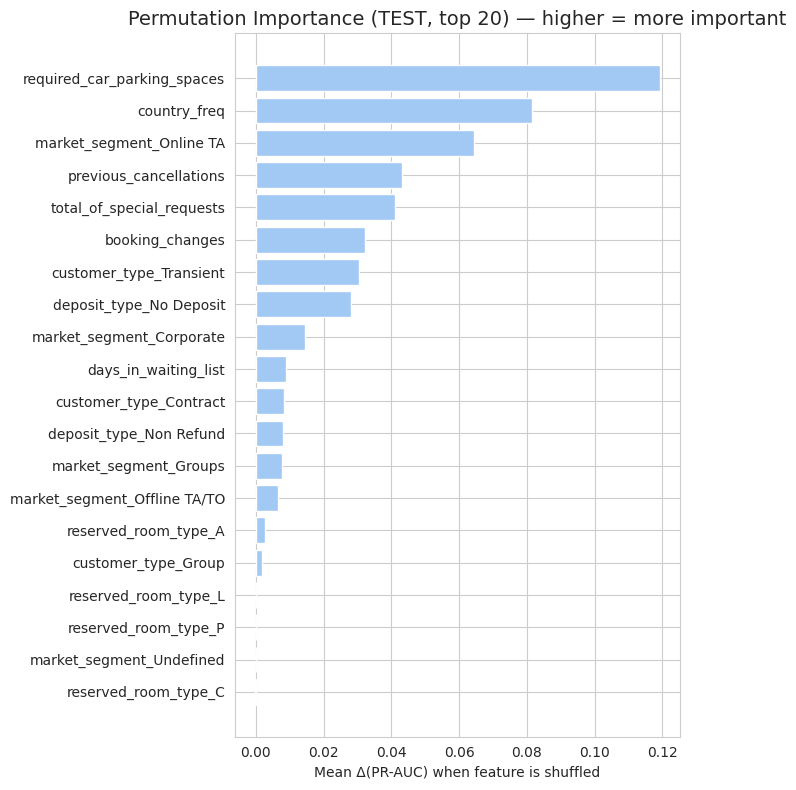

In [ ]:
top_k = 20
imp_top = perm_imp.head(top_k).iloc[::-1]
import matplotlib.pyplot as plt
plt.figure(figsize=(7,8))
plt.barh(imp_top.index, imp_top.values)
plt.title("Permutation Importance (TEST, top 20) — higher = more important", fontsize=14)
plt.xlabel("Mean Δ(PR-AUC) when feature is shuffled")
plt.tight_layout(); plt.show()

**Interpretations**
* `required_car_parking_spaces, country_freq, market_segment_Online TA, previous_cancellations` are the features our model leans on most to predict `is_canceled`.

For more detailed and values and interactions that **pushes toward cancel** or **toward not-cancel** we'll see on **SHAP**

After knowing the feature importance we want to do the SHAP (global + local) on TEST (model-agnostic & version-safe). FIrst we wrap arrays in dataframe so SHAP keeps names.

In [ ]:

Xt_train_df = pd.DataFrame(Xt_train, columns=feat_names)
Xt_test_df  = pd.DataFrame(Xt_test,  columns=feat_names)


After wrap the arrays next we are going to make the background, model-agnostic explainer, global view and local view.

PermutationExplainer explainer: 1532it [02:37,  9.08it/s]


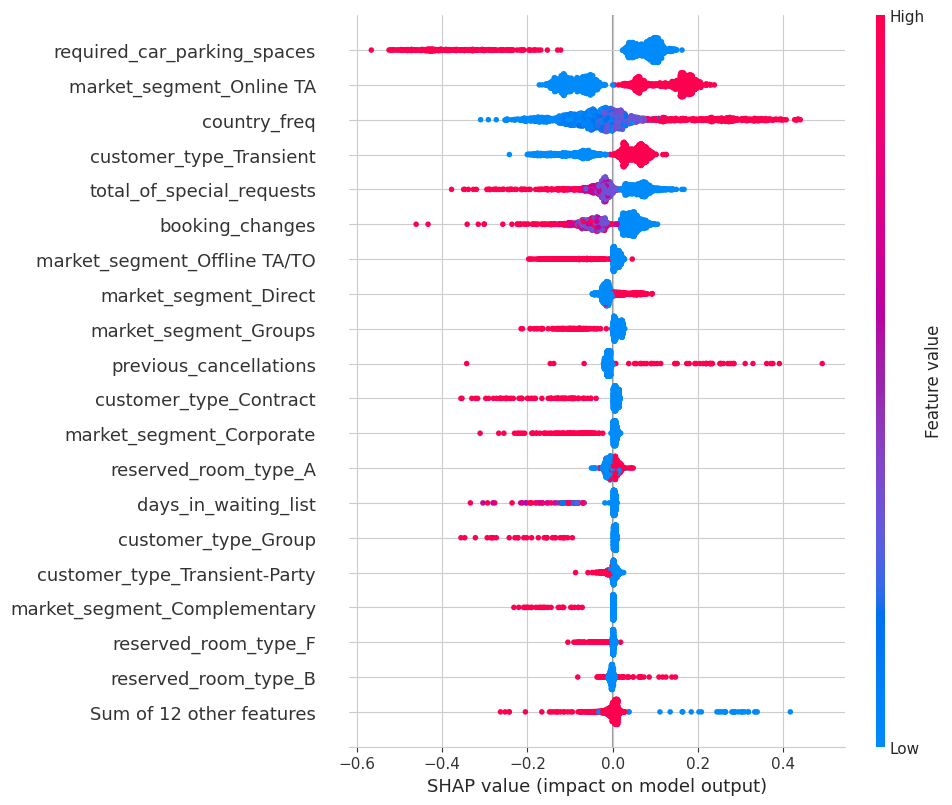

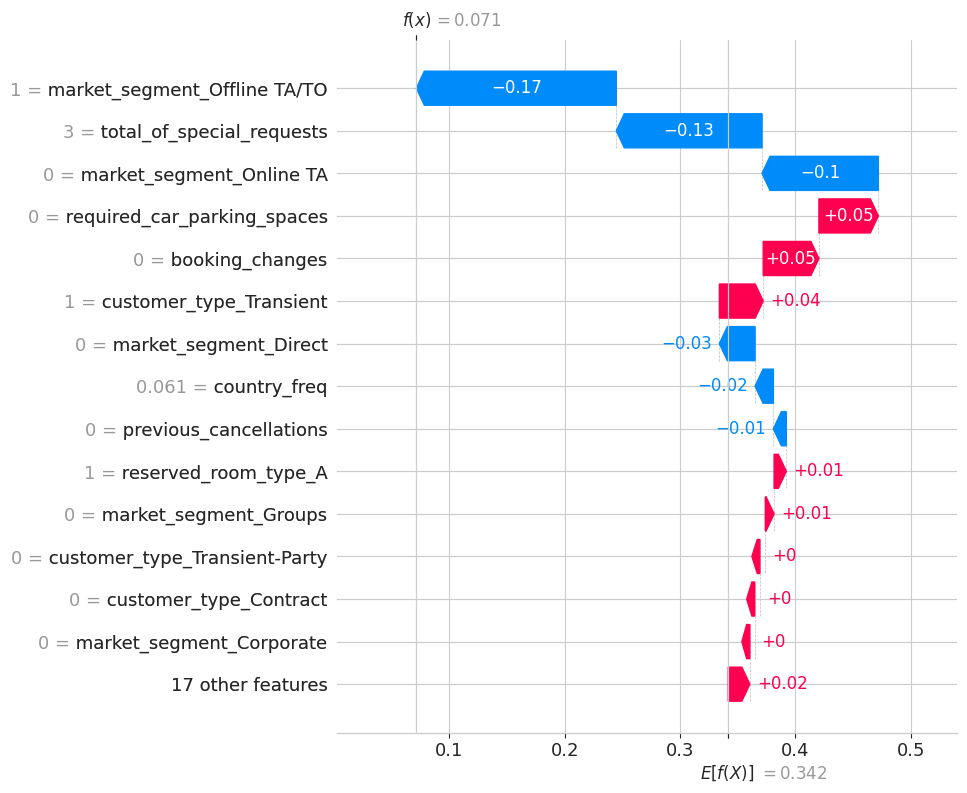

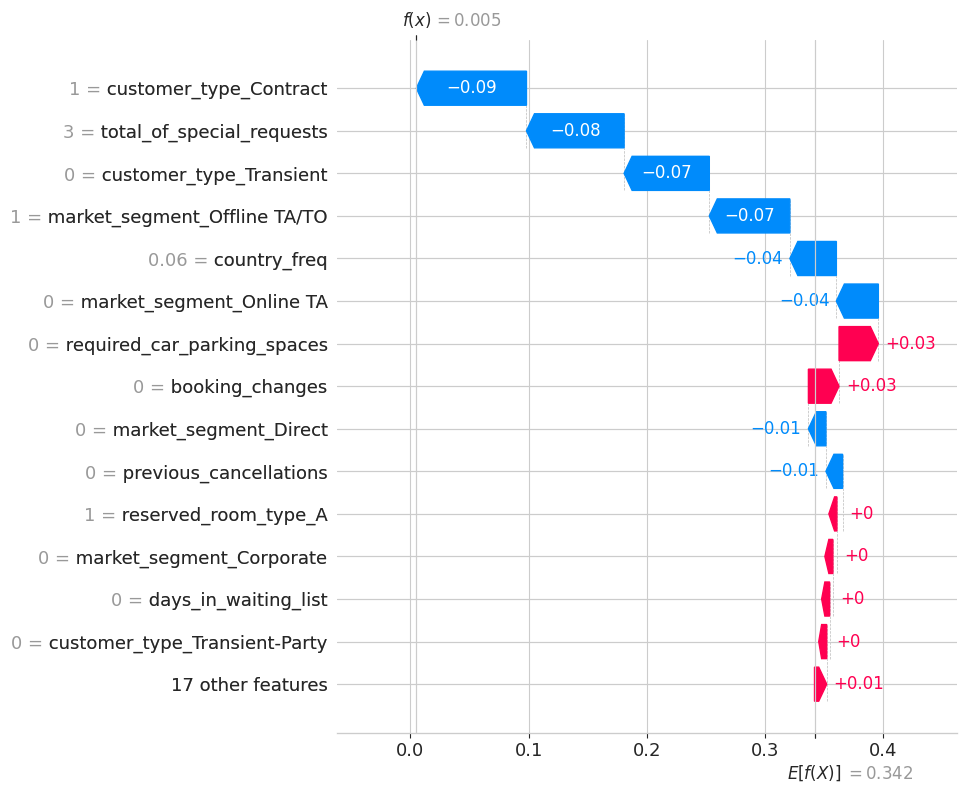

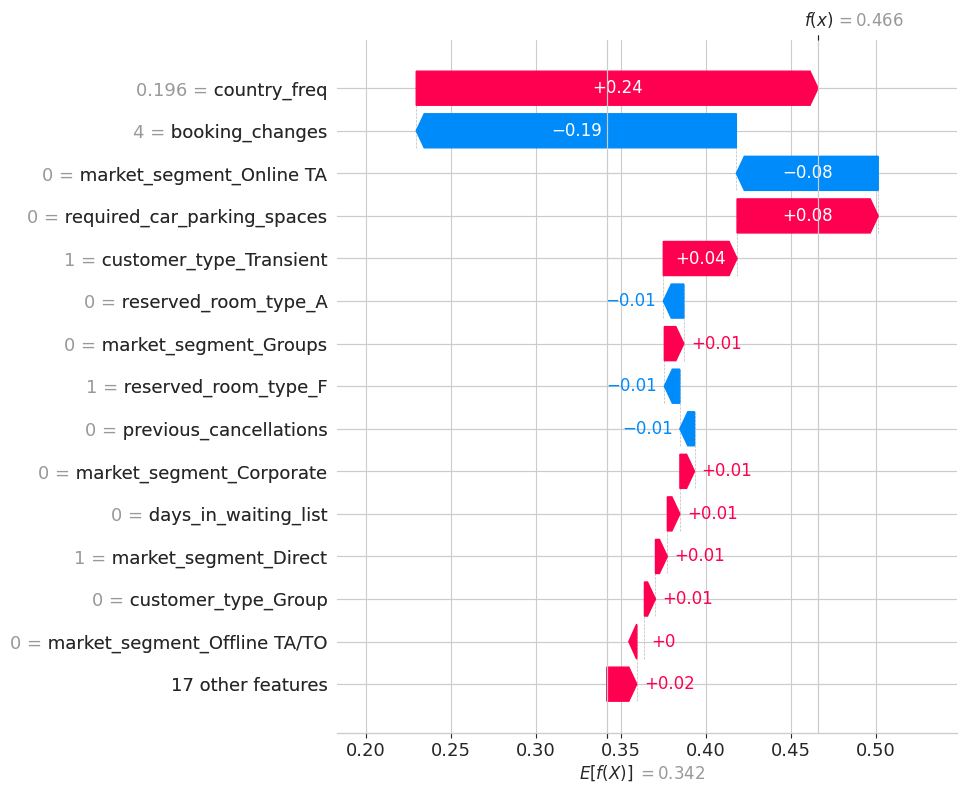

In [ ]:
rng = np.random.RandomState(42)
bg_idx = rng.choice(Xt_train_df.shape[0], size=min(200, Xt_train_df.shape[0]), replace=False)
background = Xt_train_df.iloc[bg_idx]

explainer = shap.Explainer(lambda X: model.predict_proba(np.asarray(X))[:, 1], background)
shap_vals_test = explainer(Xt_test_df)

shap.plots.beeswarm(shap_vals_test, max_display=20, show=True)

for i in [0, 1, 2]:
    shap.plots.waterfall(shap_vals_test[i], max_display=15, show=True)

#### **INTERPRETATIONS**

**Global Beeswarm (summary plot)**
* Baseline average risk: 34.2%
* Feature reducing risk (↓): parking spaces requested, multiple special requests, booing changes, high country frequency.

* Feature increasing risk (↑): Online TA/OTA bookings, transient customers, previous cancellations, low country frequency.


**SHAP 1 - f(x) = 0.071→ 7.1% risk**
* Offline travel agent booking (stable)
* 3 special requests (commitment).
* Not booked via OTA.

**Business meaning**: this type of guest 7.1% chance of canceling. Treat as confirmed; little to no overbooking buffer needed.

------------------------

**SHAP 2 - f(x) = 0.005 → 0.5% risk**
* Contracat customer (highly reliable)
* 3 special requests (strong engagement)
* Offline agent booking
* Not transient, not OTA.

**Business meaning:**
This guest has just a 0.5% chance of canceling. This is essentially guaranteed revenue. No need for overbooking.


--------------

**SHAP 3 - f(x) = 0.466 → 46.6% risk**
* From a country with high historical cancellations.
* No parking request (less committed).
* Transient cusstomer (less loyal).
* Booking changes helped, but not enough.
**Business meaning**: This guest has **46.6% chance of cancelling**.


After knowing the SHAP, we log diagnostic to `META` 9lightweight). Which keeps a small audit trail for reparts and for the joblib budnle

In [ ]:
META.update({
    "test_report": test_report,
    "importance_top15": {k: float(v) for k, v in perm_imp.head(15).items()},
    "interpretability": {
        "shap_background_size": int(background.shape[0]),
        "explain_model": type(model).__name__
    }
})
print("[12.6] META updated with TEST metrics + diagnostics.")

[12.6] META updated with TEST metrics + diagnostics.


## **Step 12. Finalize the model (joblib)**

* Save **one artifact**: `bundle = {"pipeline": fitted_pipeline, "meta": {...}} via joblib.dump`
* `meta` includes `expected_input_cols, schema_dtypes, num_cols, cat_cols, feature_names_out`, frequency maps + fallback, chosen threshold, library versions, and `leakage_excluded.`

**outcome**: a **portable, deeterministic** model.

We started by doing pre-checks

In [ ]:
assert 'FINAL_MODEL' in globals() and 'FINAL_THRESHOLD' in globals(), "Finish Step 11 first."
assert 'META' in globals(), "META is required (schema, feature names, versions, etc.)."

Then we build a clean bundle (model + threshold + metadata). It's started by making sure these keys exist in `META`

In [ ]:

META.setdefault("expected_input_cols", list(X_train.columns))
META.setdefault("feature_names_out", META.get("feature_names_out", []))
META.setdefault("schema_dtypes", {c: str(X_train[c].dtype) for c in X_train.columns})
META.setdefault("versions", {
    "sklearn": sklearn.__version__, "pandas": pd.__version__, "numpy": np.__version__
})


{'sklearn': '1.6.1', 'pandas': '2.2.2', 'numpy': '2.0.2'}

Then we save the bundle. we use Calibrated, threshold, and meta (schema, splits, feature_names_out, etc) based on previous that we have the done before

In [ ]:
bundle = {
    "model_calibrated": FINAL_MODEL,
    "threshold": float(FINAL_THRESHOLD),
    "meta": META,
}

os.makedirs("artifacts", exist_ok=True)
joblib.dump(bundle, "artifacts/hotel_cancellation_final.joblib")
with open("artifacts/hotel_cancellation_meta.json", "w") as f:
    json.dump(META, f, indent=2)

print("Saved:")
print(" - artifacts/hotel_cancellation_final.joblib")
print(" - artifacts/hotel_cancellation_meta.json")

Saved:
 - artifacts/hotel_cancellation_final.joblib
 - artifacts/hotel_cancellation_meta.json


# **CONCLUSION**

1. **Baseline risk is high:**
On average, 34% of bookings are canceled. This means overbooking and cancellation management are critical to protecting revenue.
2. **Stable customer signals (low cancellation risk):**
* Contract customers (0.5% risk).
* Offline travel agents / tour operators (7.1% risk).
* Guests with multiple special requests (consistently low risk).
* Repeat-country guests (loyalty effect).
These bookings are safe to trust.
3. **Risky customer signals (high cancellation risk):**
* Transient customers (short-term, less loyal).
* Online travel agent (OTA) bookings (higher churn).
* Guests from low-frequency countries (up to 46.6% risk).
* No parking requests (lower commitment).
* These bookings are unreliable and cancellation-prone.
4. **Individual predictions show clear separation:**
* Some customers have as little as 0.5% risk (safe to count as confirmed).
* Others show 46.6% risk (nearly half likely to cancel).

# **RECOMMENDATIONS**

1.**Overbooking strategy**
* Reduce overbooking for stable segments (contract, offline agents, special requests).
* Increase buffer for high-risk groups (OTA, transient, low-frequency countries).
2. **Cancellation policies**
* Flexible policies for loyal/repeat customers.
* Stricter policies (non-refundable deposits, cancellation fees) for OTA and transient segments, especially from high-risk countries.
3. **Customer segmentation in practice**
* Use model outputs to label bookings by risk % (green = <10%, yellow = ~30%, red = >40%).
* Empower front desk and revenue managers to act differently by segment.
4. **Revenue optimization**
* Trust low-risk bookings: don’t overbook against them → reduces walk risk.
* Monitor high-risk bookings: forecast cancellations early, open more availability, or upsell backup guests.

**Final takeaways for stakeholders:**

By integrating SHAP-based risk predictions, the hotel can protect revenue, reduce guest dissatisfaction from overbooking, and apply smarter cancellation policies. Stable customers bring guaranteed revenue, while risky ones require hedging and stricter terms.